# 0. Import packages

In [1]:
import warnings 
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 100)

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from yellowbrick.cluster import SilhouetteVisualizer

# 1. Load data

- financial_statements.csv
- security_daily.csv

In [2]:
financial_statements = pd.read_csv('financial_statements.csv')
security_daily = pd.read_csv('security_daily.csv')

# 2. Clustering

In [3]:
# function to plot a boxplot and a histogram along the same scale
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# Shilhouette analysis to choose optimal k
def Silhouette_analysis(df):
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    silhouette_avg = []

    for num_clusters in range_n_clusters:

        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters, random_state=2022).fit(df)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg.append(silhouette_score(df, cluster_labels))

    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('number of clusters, K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis', fontsize=20)
    plt.show()


def run_kmeans(df, num_clusters):

    # fit kmeans
    kmeans = KMeans(n_clusters=num_clusters,
                    random_state=2022).fit(df)

    # print out scores
    print('Silhouette score: ',
          round(metrics.silhouette_score(df, kmeans.labels_, metric='euclidean'), 3))
    print('Davies-Bouldin score: ',
          round(davies_bouldin_score(df, kmeans.labels_), 3))

    # add cluster labels to dataset
    df['cluster'] = kmeans.labels_

    # sort dataset by log market cap (for later use of visualization)
    as_is_list = df.groupby('cluster').median()['log_market_cap'].sort_values(ascending=False).keys()
    to_be_list = range(1, num_clusters+1)
    replacing_dict = dict(zip(as_is_list, to_be_list))
    df['cluster'] = df['cluster'].replace(replacing_dict)

    # plot pie chart for the number of samples in each cluster
    sns.set()
    counts = df['cluster'].value_counts()
    counts.plot(kind='pie', title='Cluster Pie', figsize=[5, 5],
                autopct=lambda p: '{:.0f}% ({:.0f})'.format(p, (p/100)*counts.sum()))
    plt.show()


def plot_scatterplot(df, features):

    if 'class' in df.columns:  # df_classified 들어오면
        df_temp = df.copy()
        g = sns.relplot(
            data=df_temp, y=df_temp[features[0]], x=df_temp[features[1]], hue="class",  palette='gist_rainbow')
        g.set(xlim=(0, 5))
        g.set(ylim=(0, 0.5e10))
        g.set(xlabel="PBR (rescaled)", ylabel="Market Cap (rescaled)")
        g.fig.suptitle("Style map", fontsize=20)
        g.fig.subplots_adjust(top=0.9)
    elif len(features) == 2:
        g = sns.relplot(
            data=df, y=df[features[0]], x=df[features[1]], hue="cluster",  palette='gist_rainbow')
        g.fig.suptitle("Clustering result with 2 features", fontsize=20)
        g.fig.subplots_adjust(top=0.9)
    elif len(features) == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        g = ax.scatter(df[features[0]], df[features[1]],
                       df[features[2]], c=df['cluster'], cmap='gist_rainbow')
        ax.set_title('Clustering result with 3 features', fontsize=20)
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        legend = ax.legend(*g.legend_elements(), loc="center right",
                           title="cluster", borderaxespad=-8, ncol=1)
        ax.add_artist(legend)

    else:
        print('you can plot only 2 or 3 features')

## A. Financial variables

In [4]:
df_fin = financial_statements.copy()

In [5]:
'변수 EDA'
features = ['market_cap', 'PER', 'EPS',
            'ROE', 'net_income', 'net_cash_flow', 'volatility']
            
# for f in features:
#     histogram_boxplot(df_fin, f, bins=50, kde=True, figsize=(10, 5))


In [6]:
'전처리'

# 이상치 3%씩 없애기
features = ['EPS', 'net_income', 'PER', 'ROE', 'net_cash_flow']
for f in features:
    min = np.quantile(df_fin[f], 0.03)
    max = np.quantile(df_fin[f], 0.97)
    df_fin = df_fin[(df_fin[f] >= min) & (df_fin[f] <= max)]

# 로그 변환
df_fin['log_market_cap'] = np.log1p(df_fin['market_cap'].astype(float))

# 표준화
features = ['log_market_cap', 'volatility', 'EPS',
            'PER', 'ROE', 'net_cash_flow', 'net_income']
sc = StandardScaler()
scaled = sc.fit_transform(df_fin[features])
df_fin_scaled = pd.DataFrame(scaled, columns=features)


In [7]:
# for f in features:
#     histogram_boxplot(df_fin_scaled, f, bins=50, kde=True, figsize=(10, 5))


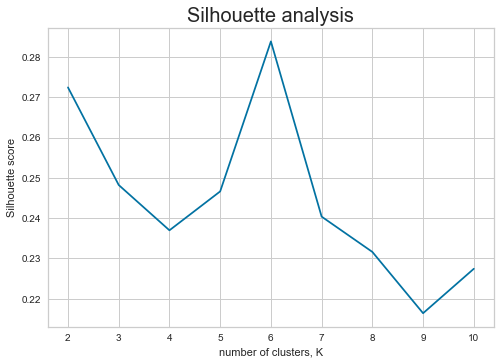

In [8]:
Silhouette_analysis(df_fin_scaled)


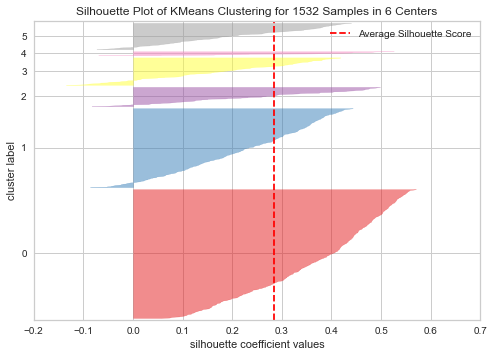

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1532 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [9]:
optimal_k = 6

visualizer = SilhouetteVisualizer(
    KMeans(optimal_k, random_state=2022)).fit(df_fin_scaled)
visualizer.show()

Silhouette score:  0.284
Davies-Bouldin score:  1.203


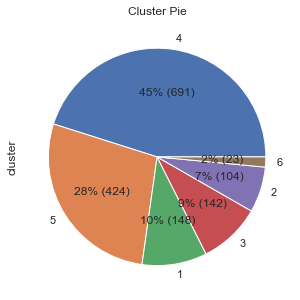

In [10]:
run_kmeans(df_fin_scaled, num_clusters=6)

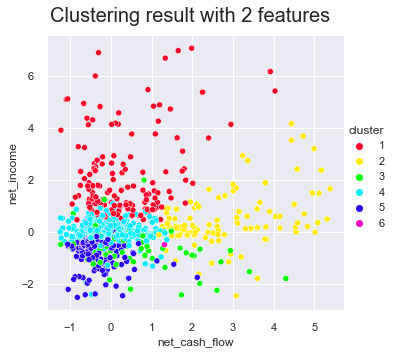

In [11]:
plot_scatterplot(df_fin_scaled, ['net_income', 'net_cash_flow'])

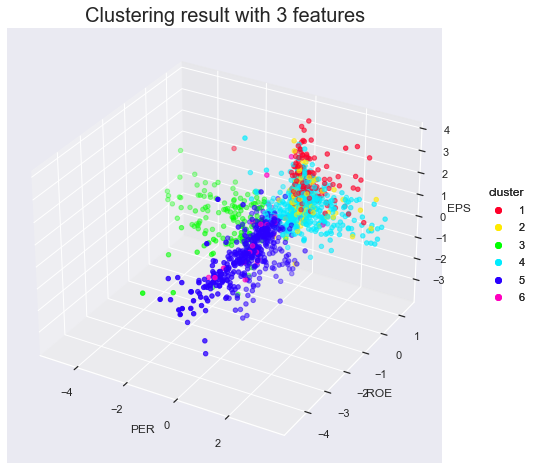

In [12]:
plot_scatterplot(df_fin_scaled, ['PER', 'ROE', 'EPS'])


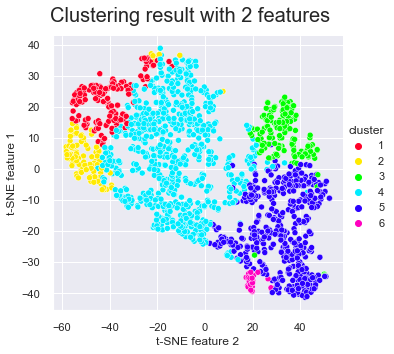

In [13]:
tsne = TSNE(n_components=2, random_state=2)

cluster = df_fin_scaled['cluster']
stocks = df_fin_scaled.drop(columns=['cluster'])
stocks_tsne = tsne.fit_transform(stocks)
stocks_tsne_df = pd.DataFrame(
    stocks_tsne, columns=['t-SNE feature 1', 't-SNE feature 2'])
stocks_tsne_df['cluster'] = list(cluster)

plot_scatterplot(stocks_tsne_df, ['t-SNE feature 1', 't-SNE feature 2'])


## B. Style variables

In [14]:
df_style = financial_statements.copy()

In [15]:
'변수 EDA'
features = ['market_cap', 'PER', 'PBR']

# for f in features:
#     histogram_boxplot(df_style, f, bins=50, kde=True, figsize=(10, 5))


In [16]:
'전처리'

# 이상치 3%씩 없애기
features = ['PER', 'PBR']
for f in features:
    min = np.quantile(df_style[f], 0.03)
    max = np.quantile(df_style[f], 0.97)
    df_style = df_style[(df_style[f] >= min) & (df_style[f] <= max)]

# 로그 변환
df_style['log_market_cap'] = np.log1p(df_style['market_cap'].astype(float))

# 표준화
features = ['log_market_cap', 'PER', 'PBR']
sc = StandardScaler()
scaled = sc.fit_transform(df_style[features])
df_style_scaled = pd.DataFrame(scaled, columns=features)


In [17]:
# for f in features:
#     histogram_boxplot(df_style_scaled, f, bins=50, kde=True, figsize=(10, 5))


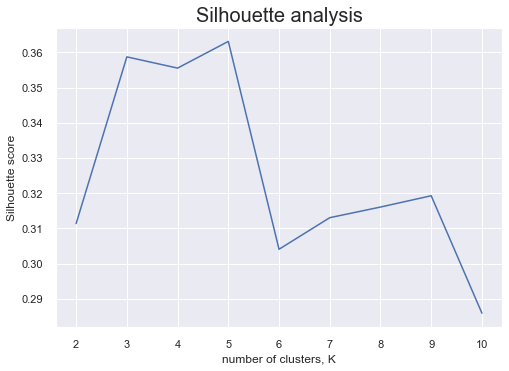

In [18]:
Silhouette_analysis(df_style_scaled)

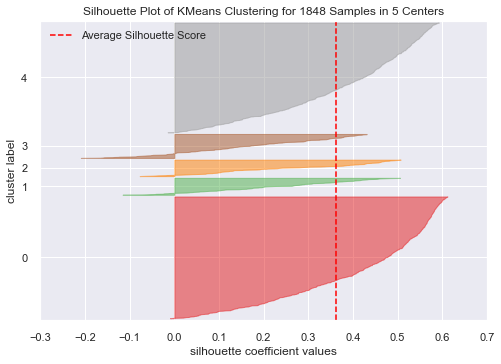

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1848 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
optimal_k = 5

visualizer = SilhouetteVisualizer(
    KMeans(optimal_k, random_state=2022)).fit(df_style_scaled)
visualizer.show()

Silhouette score:  0.363
Davies-Bouldin score:  1.053


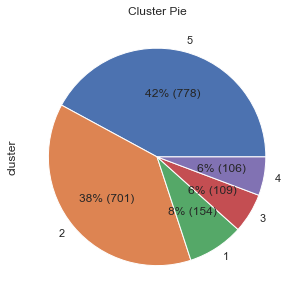

In [20]:
run_kmeans(df_style_scaled, 5)

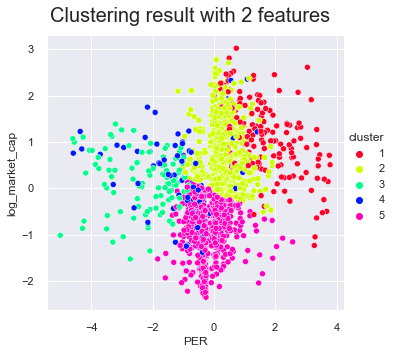

In [21]:
plot_scatterplot(df_style_scaled, ['log_market_cap', 'PER'])

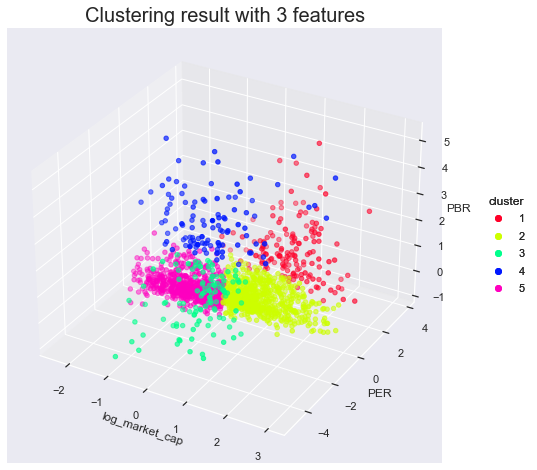

In [22]:
plot_scatterplot(df_style_scaled, features)

## C. Classification with style

In [23]:
df_style_class = financial_statements.copy()

In [24]:
def style_classification(df):

    # market cap, top 40%
    size_df_top = df[df["market_cap"] >= np.quantile(df['market_cap'], 0.6)]
    tic_list_large = list(size_df_top['tic'].unique())

    mask = df['tic'].isin(tic_list_large)
    large = df[mask]
    small = df[~mask]
    large['size'] = 'large'
    small['size'] = 'small'
    df_sized = pd.concat([large, small])

    # PBR, top 50%
    value_df_top = df[df["PBR"] >=
                      np.quantile(df['PBR'], 0.5)]
    tic_list_growth = list(value_df_top['tic'].unique())

    mask = df['tic'].isin(tic_list_growth)
    growth = df[mask]
    value = df[~mask]
    growth['value'] = 'growth'
    value['value'] = 'value'
    df_valued = pd.concat([growth, value])

    # merge dataset
    cols = list(df_sized.drop(columns=['size']).columns)
    data_classified = pd.merge(df_sized, df_valued, on=cols)
    data_classified['class'] = data_classified['size'] + \
        '_' + data_classified['value']

    return data_classified


df_classified = style_classification(df_style_class)

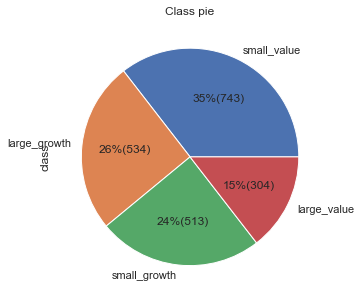

In [25]:
sns.set()
counts = df_classified['class'].value_counts()
counts.plot(kind='pie', title='Class pie', figsize=[5, 5],
            autopct=lambda p: '{:.0f}%({:.0f})'.format(p, (p/100)*counts.sum()))
plt.show()

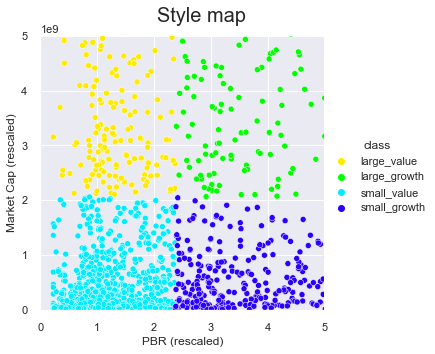

In [26]:
plot_scatterplot(df_classified, ['market_cap', 'PBR'])

# 3. Analysis

## Largest firms

In [27]:
def largest_firms(df):

    name_dict = {}

    if 'class' in df.columns:  # df_classified 들어온 경우
        class_list = df_classified['class'].unique()
        for i in class_list:
            temp = df_classified[df_classified['class'] == i]
            temp = temp.sort_values('market_cap', ascending=False)
            name_dict['cluster_{}'.format(i)] = temp['name'][:5].tolist()
    else:
        k = len(df['cluster'].unique())
        for i in range(1, k+1):
            temp = df[df['cluster'] == i]
            temp = temp.sort_values('market_cap', ascending=False)
            name_dict['cluster_{}'.format(i)] = temp['name'][:5].tolist()

    return pd.DataFrame(name_dict, index=range(1,6))


In [28]:
df_fin['cluster'] = list(df_fin_scaled['cluster'])
df_style['cluster'] = list(df_style_scaled['cluster'])


In [29]:
df_fin_names = largest_firms(df_fin)
df_fin_names


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
1,INTUITIVE SURGICAL INC,FIDELITY NATIONAL INFO SVCS,PINTEREST INC,DOMINION ENERGY INC,BRIDGEBIO PHARMA INC,ARCTURUS THERAPETCS HOLD INC
2,FISERV INC,KRAFT HEINZ CO,SEAGEN INC,ZIMMER BIOMET HOLDINGS INC,INVITAE CORP,ASSEMBLY BIOSCIENCES INC
3,DUKE ENERGY CORP,MARRIOTT INTL INC,ZENDESK INC,WILLIAMS COS INC,NOVAVAX INC,CHINA AUTOMOTIVE SYSTEMS INC
4,GLOBAL PAYMENTS INC,IQVIA HOLDINGS INC,AVALARA INC,ROLLINS INC,TG THERAPEUTICS INC,HEAT BIOLOGICS INC
5,NORFOLK SOUTHERN CORP,KINDER MORGAN INC,SAREPTA THERAPEUTICS INC,AES CORP (THE),PTC THERAPEUTICS INC,WESTWATER RESOURCES INC


In [30]:
df_style_names = largest_firms(df_style)
df_style_names


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
1,META PLATFORMS INC,JPMORGAN CHASE & CO,EXACT SCIENCES CORP,LILLY (ELI) & CO,MATADOR RESOURCES CO
2,JOHNSON & JOHNSON,UNITEDHEALTH GROUP INC,BIOMARIN PHARMACEUTICAL INC,TEXAS INSTRUMENTS INC,SMILEDIRECTCLUB INC
3,PAYPAL HOLDINGS INC,BANK OF AMERICA CORP,LIVE NATION ENTERTAINMENT,LOCKHEED MARTIN CORP,MACROGENICS INC
4,COCA-COLA CO,VERIZON COMMUNICATIONS INC,GUARDANT HEALTH INC,ILLINOIS TOOL WORKS,COHERUS BIOSCIENCES INC
5,MERCK & CO,COMCAST CORP,HOWMET AEROSPACE INC,MODERNA INC,MAGNOLIA OIL & GAS CORP


In [31]:
df_classified_names = largest_firms(df_classified)
df_classified_names


,cluster_large_value,cluster_large_growth,cluster_small_value,cluster_small_growth
1,JPMORGAN CHASE & CO,AMAZON.COM INC,FULTON FINANCIAL CORP,SOUTHWESTERN ENERGY CO
2,BANK OF AMERICA CORP,TESLA INC,PDC ENERGY INC,MEDNAX INC
3,COMCAST CORP,META PLATFORMS INC,ALLEGHENY TECHNOLOGIES INC,PRECIGEN INC
4,AT&T INC,JOHNSON & JOHNSON,FIRST MERCHANTS CORP,NGM BIOPHARMACEUTICAL INC
5,EXXON MOBIL CORP,MASTERCARD INC,WESBANCO INC,TPI COMPOSITES INC


## A. Financial variables

In [32]:
def plot_boxplot(df, features):

    n_features = len(features)

    fig, axes = plt.subplots(1, n_features, figsize=(25, 5))
    for i in range(n_features):
        feature = df[features].columns[i]
        sns.boxplot(x="cluster", y=feature, data=df, ax=axes[i])
        axes[i].set_title("{}".format(feature), fontsize=15)
        axes[i].set_ylabel('')
    plt.show()


def plot_histogram(df, features):
    for i in range(len(features)):
        g = sns.FacetGrid(df, col='cluster')
        g.map_dataframe(sns.histplot, x=features[i], bins=30)


def plot_avg_table(df, features):

    temp = df.copy()
    temp = temp[features+['cluster']]

    # 클러스터 별 평균
    df_table = temp.groupby('cluster').mean()

    # 색칠
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    df_table = df_table.style.background_gradient(cmap=cm)
    display(df_table)


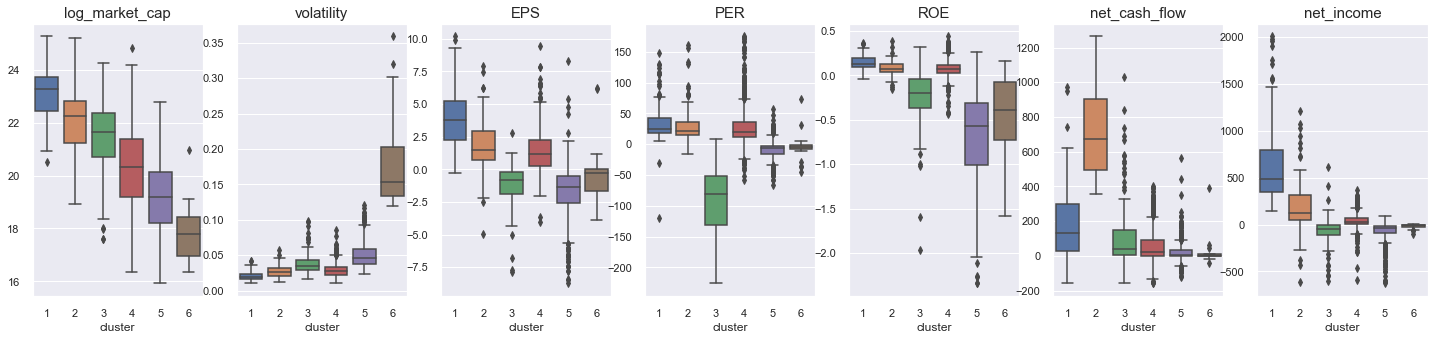

In [33]:
features = ['log_market_cap', 'volatility', 'EPS',
            'PER', 'ROE', 'net_cash_flow', 'net_income']

plot_boxplot(df_fin, features)

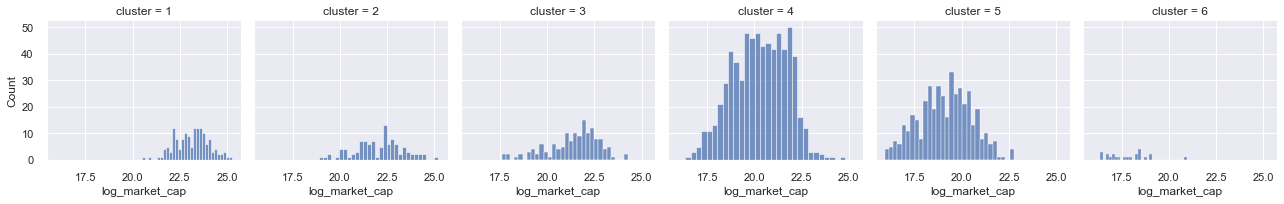

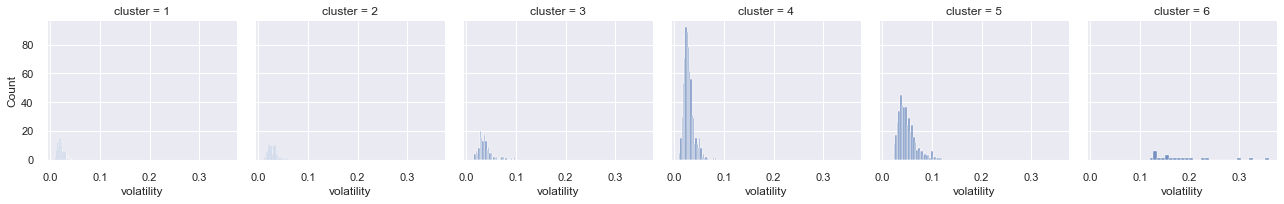

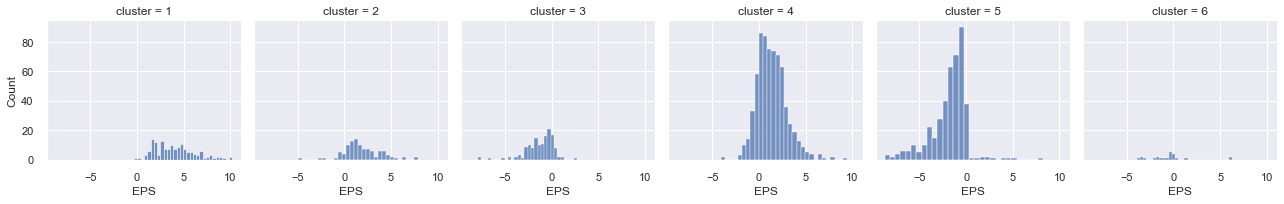

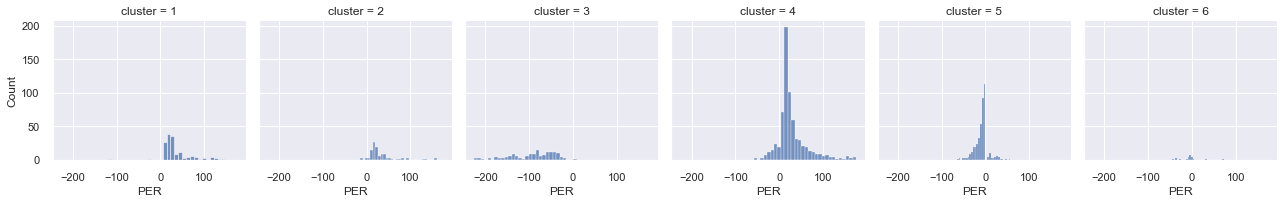

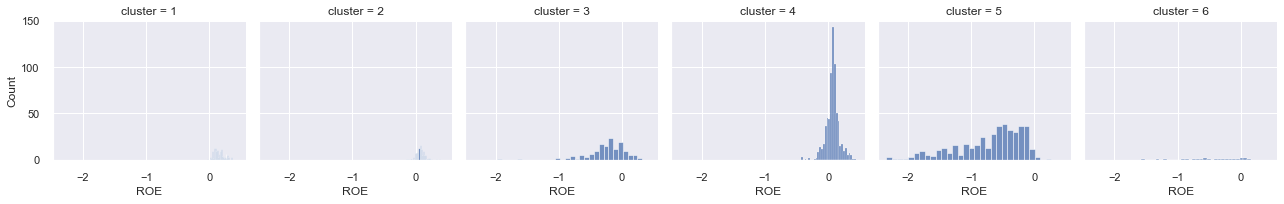

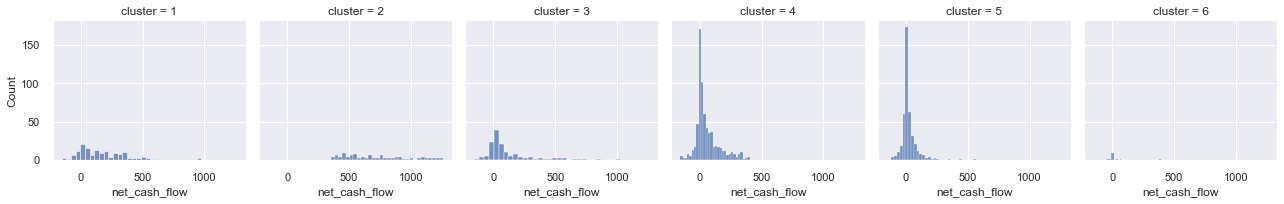

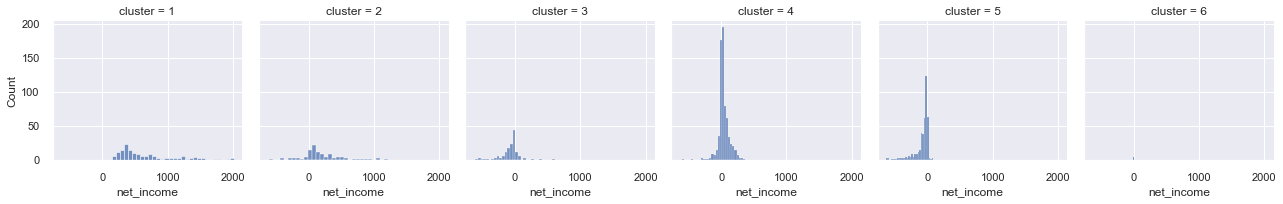

In [34]:
plot_histogram(df_fin, features)

In [35]:
plot_avg_table(df_fin, features)

,log_market_cap,volatility,EPS,PER,ROE,net_cash_flow,net_income
cluster,,,,,,,
1,23.143487,0.020301,4.041689,33.972872,0.149885,176.990230,655.284770
2,22.059823,0.026975,1.913433,31.048798,0.077894,717.509567,193.128269
3,21.408351,0.038003,-1.224718,-91.481338,-0.248669,113.574099,-71.282655
4,20.270595,0.029023,1.375094,28.247340,0.073624,57.531339,39.433779
5,19.140726,0.050010,-1.826705,-9.228061,-0.707828,21.716849,-79.047538
6,17.812397,0.182299,-0.408696,-4.603261,-0.472870,20.841652,-18.697435


## B. Style variables

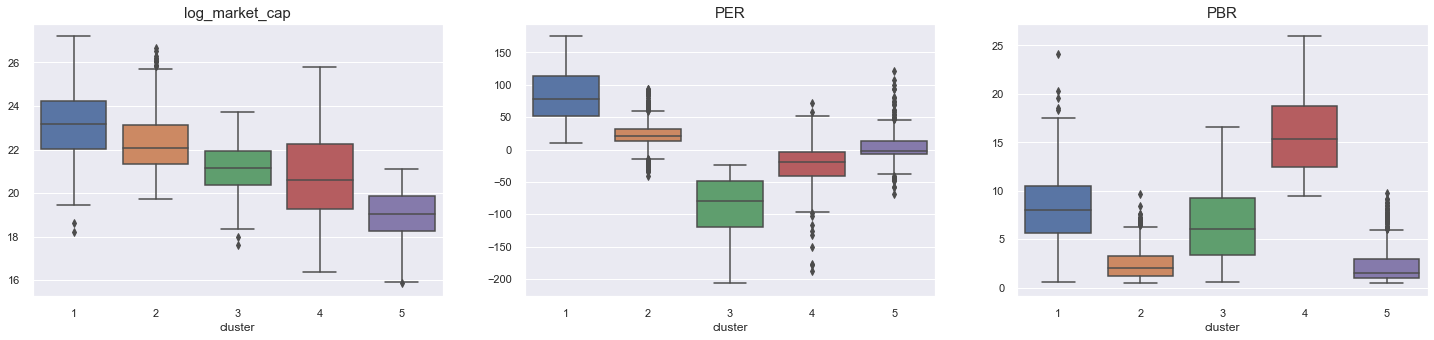

In [36]:
features = ['log_market_cap', 'PER', 'PBR']

plot_boxplot(df_style, features)

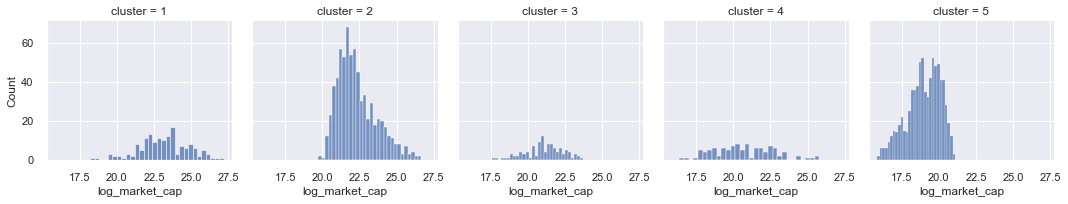

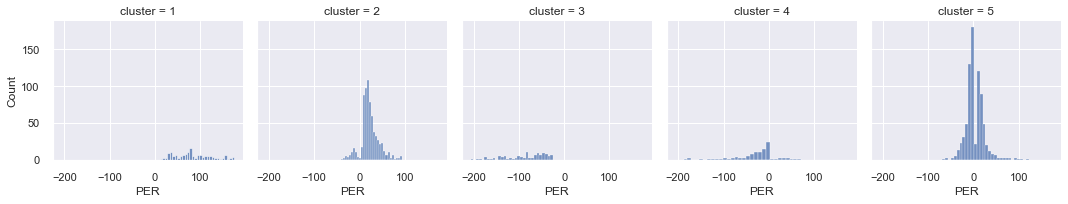

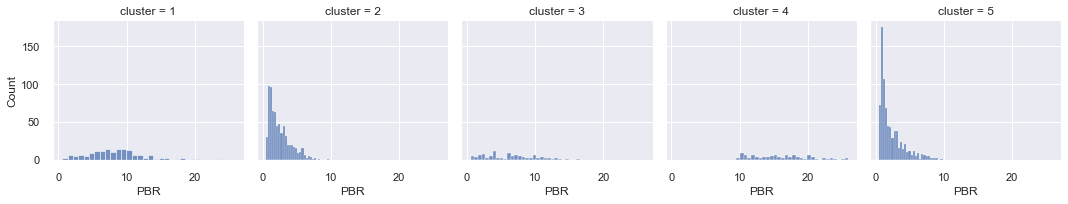

In [37]:
plot_histogram(df_style, features)

In [38]:
plot_avg_table(df_style, features)

,log_market_cap,PER,PBR
cluster,,,
1,23.124188,84.869597,8.337851
2,22.323108,23.294966,2.457762
3,21.105701,-85.737743,6.281294
4,20.724720,-28.471811,15.999170
5,18.978872,3.100269,2.243172


## C. Classification with style
- boxplot
    - log_market_cap 추가
    - 이상치 삭제 추가 

In [39]:
df_classified_analysis = df_classified.copy()

In [40]:
# 이상치 3%씩 없애기
features = ['EPS', 'net_income', 'PER', 'ROE', 'net_cash_flow']
for f in features:
    min = np.quantile(df_classified_analysis[f], 0.03)
    max = np.quantile(df_classified_analysis[f], 0.97)
    df_classified_analysis = df_classified_analysis[(df_classified_analysis[f] >= min) & (df_classified_analysis[f] <= max)]

# 로그 변환
df_classified_analysis['log_market_cap'] = np.log1p(df_classified_analysis['market_cap'].astype(float))


In [41]:
def plot_boxplot_classification(df, features):

    n_features = len(features)

    fig, axes = plt.subplots(1, n_features, figsize=(25, 5))
    for i in range(n_features):
        feature = df[features].columns[i]
        sns.boxplot(x="class", y=feature, data=df, ax=axes[i])
        axes[i].set_title("{}".format(feature), fontsize=15)
        axes[i].set_ylabel('')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)
    plt.show()


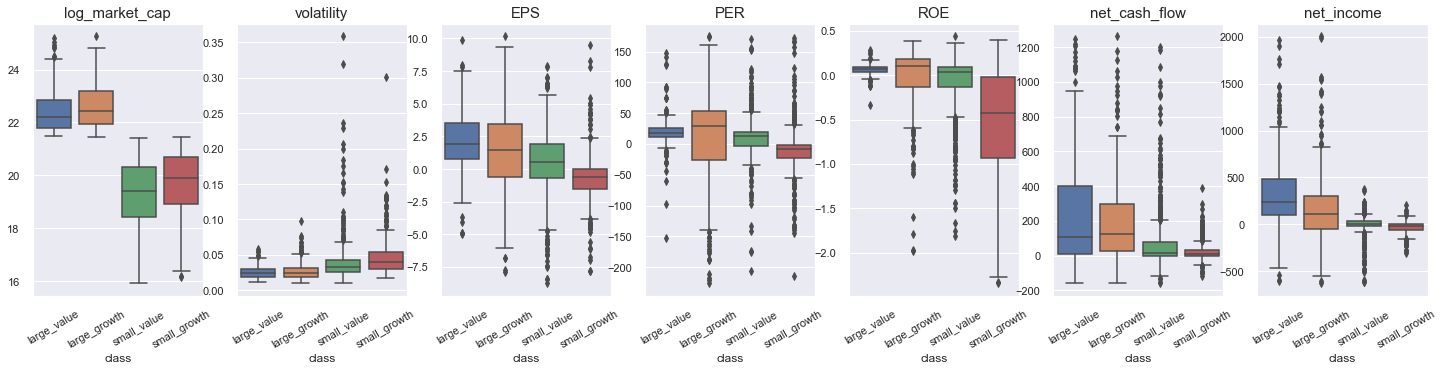

In [42]:
features = ['log_market_cap', 'volatility', 'EPS',
            'PER', 'ROE', 'net_cash_flow', 'net_income']

plot_boxplot_classification(df_classified_analysis, features)


In [43]:
def plot_avg_table_classification(df, features):

    temp = df.copy()
    temp = temp[features+['class']]

    # 클러스터 별 평균
    df_table = temp.groupby('class').mean()

    # 색칠
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    df_table = df_table.style.background_gradient(cmap=cm)
    display(df_table)


In [44]:
plot_avg_table_classification(df_classified_analysis, features)

,log_market_cap,volatility,EPS,PER,ROE,net_cash_flow,net_income
class,,,,,,,
large_growth,22.595455,0.026831,1.363923,11.311698,-0.022923,199.396682,177.956045
large_value,22.448989,0.025575,2.124186,20.730762,0.060035,259.638401,349.697320
small_growth,19.698659,0.046631,-0.642689,-7.868692,-0.542556,22.903694,-33.232794
small_value,19.297846,0.038938,0.394488,10.496966,-0.079792,77.808894,-3.053063


## market (new)

In [90]:
def get_corr_return_new(df_in):

    df = df_in.copy()

    # data_classified 들어왔을 경우
    if 'class' in df.columns:
        df = df.rename(columns={'class': 'cluster'})
        df['cluster'] = df['cluster'].replace({'large_growth': 1, 'large_value': 2,
                                               'small_growth': 3, 'small_value': 4})

    # 클러스터 별 tic_list 담기 (key: 클러스터 번호, value: tic 리스트)
    tic_list_dict = {}
    for key, value in df.groupby('cluster'):
        tic_list_dict[key] = list(value['tic'])

    # 2021년 가격 가져오기
    security_daily_1yr = security_daily[security_daily['datadate'].between(
        20210104, 20210704)]

    # 분석 대상 주식
    daily_price = security_daily_1yr[security_daily_1yr['tic'].isin(
        list(df['tic']))].sort_values('datadate')

    # 일별 종가 데이터 가져와서 log return 구하기
    n_clusters = len(df['cluster'].unique())
    daily_logret_dict = {}
    for k in range(1, n_clusters+1):

        # 각 클러스터 종목들의 daily close price
        prices = daily_price[daily_price['tic'].isin(tic_list_dict[k])]

        # 각 클러스터 종목들의 daily price
        df_close_dict = {}
        for tic in tic_list_dict[k]:
            price = prices[prices['tic'] == tic]['prccd'].values
            if len(price) == 126:
                df_close_dict[tic] = price
        df_close = pd.DataFrame.from_dict(df_close_dict)

        # log return 변환
        df_logret = np.log(df_close/df_close.shift(1))
        df_logret = df_logret.drop(0)  # 첫날 NaN값 삭제

        daily_logret_dict[k] = df_logret

    # intra corr 계산
    avg_intra_list = []
    for k in range(1, n_clusters+1):
        df_corr = daily_logret_dict[k].corr()
        df_corr['sum'] = df_corr.sum(axis=1) - 1
        df_corr['avg'] = df_corr['sum']/(len(df_corr)-1)
        avg_intra_list.append(df_corr['avg'].mean())
    avg_intra = np.mean(avg_intra_list)

    # inter corr 계산
    daily_logret_corr = pd.concat(daily_logret_dict, axis=1).corr()
    avg_inter_list = []
    for i in range(1, n_clusters):
        for j in range(i+1, n_clusters+1):
            rectangle = daily_logret_corr.loc[i, j]
            avg = np.nanmean(rectangle)
            avg_inter_list.append(avg)
    avg_inter = np.mean(avg_inter_list)

    # 1년 수익률 계산
    avg_logret_dict = {}
    for k in range(1, n_clusters+1):
        avg_logret_dict['cluster_{}'.format(
            k)] = daily_logret_dict[k].mean(axis=1)
    avg_logret_df = pd.DataFrame(avg_logret_dict)

    mu = avg_logret_df.mean() * len(avg_logret_df)  # annualization # 126 days
    Sigma = avg_logret_df.cov() * len(avg_logret_df)  # annualization # 126 days

    return avg_intra_list, avg_inter_list, mu, Sigma


In [91]:
import copy
cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_under("white")


def color_nan_white(val):
    """Color the nan text white"""
    if np.isnan(val):
        return 'color: white'


def color_nan_white_background(val):
     """Color the nan cell background white"""
     if np.isnan(val):
        return 'background-color: white'

In [92]:
data_dict = {'kmeans_fin': df_fin, 'kmeans_style': df_style,
             'classification_style': df_classified}

return_df_list = []
corr_df_list = []

for method, data in tqdm(data_dict.items()):

    avg_intra_list, avg_inter_list, mu, Sigma = get_corr_return_new(data)

    '''수익 상관관계 표'''
    n_clusters = len(avg_intra_list)
    corr_matrix = np.zeros((n_clusters, n_clusters))
    np.fill_diagonal(corr_matrix, avg_intra_list)

    indices = np.triu_indices(n_clusters, 1)
    corr_matrix[indices] = avg_inter_list

    # [make upper triangular matrix symmetric]
    # #get the upper triangular part of this matrix
    # X = corr_matrix.copy()
    # v = X[np.triu_indices(X.shape[0], k=0)]
    # # put it back into a 2D symmetric array
    # X = np.zeros((n_clusters, n_clusters))
    # X[np.triu_indices(X.shape[0], k=0)] = v
    # X = X + X.T - np.diag(np.diag(X))
    # corr_matrix = X.copy()

    corr_matrix = pd.DataFrame(corr_matrix)

    # fill 0s with NaNs
    corr_matrix = corr_matrix.replace(0, np.nan)


    corr_matrix.columns = ['Cluster_{}'.format(i+1) for i in range(n_clusters)]
    corr_matrix.index = ['Cluster_{}'.format(i+1) for i in range(n_clusters)]
    # 색칠
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    corr_matrix = corr_matrix.style.background_gradient(cmap=cm).applymap(lambda x: color_nan_white(x)).applymap(lambda x: color_nan_white_background(x))
    display(corr_matrix)

    '''수익 상관관계'''
    corr_df = pd.DataFrame(
        {'avg_intra': np.mean(avg_intra_list), 'avg_inter': np.mean(avg_inter_list)}, index=mu.index)
    corr_df['Method'] = method
    corr_df = corr_df.reset_index()
    corr_df_list.append(corr_df)
    
    '''1년 수익률'''
    return_df = pd.DataFrame(
        {'Mean': mu.values, 'Standard Deviation': np.diag(Sigma)}, index=mu.index)
    return_df['Method'] = method
    return_df = return_df.reset_index()
    return_df_list.append(return_df)

corr_df_concat = pd.concat(corr_df_list)
return_df_concat = pd.concat(return_df_list)


  0%|          | 0/3 [00:00<?, ?it/s]

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
Cluster_1,0.262514,0.295900,0.136110,0.219293,0.111795,0.070901
Cluster_2,nan,0.417184,0.160402,0.306824,0.155933,0.092798
Cluster_3,nan,nan,0.249587,0.154893,0.190726,0.187356
Cluster_4,nan,nan,nan,0.240692,0.142497,0.100783
Cluster_5,nan,nan,nan,nan,0.177150,0.183045
Cluster_6,nan,nan,nan,nan,nan,0.223911


 33%|███▎      | 1/3 [00:05<00:11,  5.58s/it]

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
Cluster_1,0.243923,0.212901,0.201449,0.173543,0.146562
Cluster_2,nan,0.310553,0.166337,0.135527,0.186204
Cluster_3,nan,nan,0.233048,0.218457,0.166173
Cluster_4,nan,nan,nan,0.211603,0.154999
Cluster_5,nan,nan,nan,nan,0.161168


 67%|██████▋   | 2/3 [00:14<00:07,  7.25s/it]

,Cluster_1,Cluster_2,Cluster_3,Cluster_4
Cluster_1,0.225191,0.214156,0.171565,0.164185
Cluster_2,nan,0.345019,0.146391,0.240435
Cluster_3,nan,nan,0.188593,0.151701
Cluster_4,nan,nan,nan,0.202643


100%|██████████| 3/3 [00:23<00:00,  7.67s/it]


Text(0.5, 1.0, 'Return correlations')

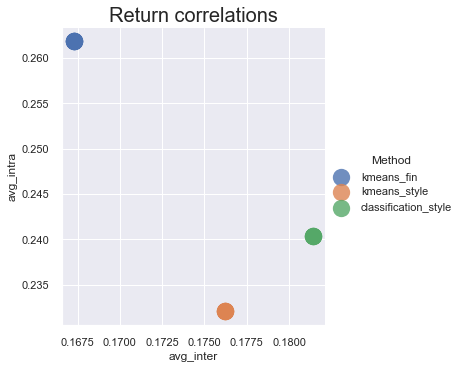

In [93]:
g = sns.lmplot(
    data=corr_df_concat,
    x="avg_inter", y="avg_intra", hue="Method",
    height=5,
    scatter_kws={"s": 300}
)

g.set_axis_labels("avg_inter", "avg_intra")
plt.title('Return correlations', fontsize=20)

(0.0, 0.3)

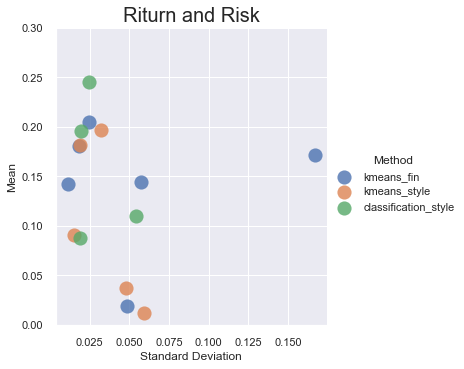

In [94]:
g = sns.lmplot(
    data=return_df_concat,
    x="Standard Deviation", y="Mean", hue="Method",
    height=5,
    scatter_kws={"s": 200},
    ci=None, fit_reg=False # turn off the shade and line 
)

g.set_axis_labels("Standard Deviation", "Mean")
plt.title('Riturn and Risk', fontsize=20)
plt.ylim(-0, 0.3)


## market

In [613]:
def get_corr_return(df_in):

    df = df_in.copy()

    # data_classified 들어왔을 경우
    if 'class' in df.columns:
        df = df.rename(columns={'class': 'cluster'})
        df['cluster'] = df['cluster'].replace({'large_growth': 1, 'large_value': 2,
                                               'small_growth': 3, 'small_value': 4})

    # 클러스터 별 tic_list 담기 (key: 클러스터 번호, value: tic 리스트)
    tic_list_dict = {}
    for key, value in df.groupby('cluster'):
        tic_list_dict[key] = list(value['tic'])

    # 2021년 가격 가져오기
    security_daily_1yr = security_daily[security_daily['datadate'].between(
        20210104, 20210704)]

    # 분석 대상 주식
    daily_price = security_daily_1yr[security_daily_1yr['tic'].isin(
        list(df['tic']))].sort_values('datadate')

    # 일별 종가 데이터 가져와서 log return 구하기
    n_clusters = len(df['cluster'].unique())
    daily_logret_dict = {}
    for k in range(1, n_clusters+1):

        # 각 클러스터 종목들의 daily close price
        prices = daily_price[daily_price['tic'].isin(tic_list_dict[k])]

        # 각 클러스터 종목들의 daily price
        df_close_dict = {}
        for tic in tic_list_dict[k]:
            price = prices[prices['tic'] == tic]['prccd'].values
            if len(price) == 126:
                df_close_dict[tic] = price
        df_close = pd.DataFrame.from_dict(df_close_dict)

        # log return 변환
        df_logret = np.log(df_close/df_close.shift(1))
        df_logret = df_logret.drop(0)  # 첫날 NaN값 삭제

        daily_logret_dict[k] = df_logret

    # intra corr 계산
    avg_intra_list = []
    for k in range(1, n_clusters+1):
        df_corr = daily_logret_dict[k].corr()
        df_corr['sum'] = df_corr.sum(axis=1) - 1
        df_corr['avg'] = df_corr['sum']/(len(df_corr)-1)
        avg_intra_list.append(df_corr['avg'].mean())
    avg_intra = np.mean(avg_intra_list)

    # inter corr 계산
    daily_logret_corr = pd.concat(daily_logret_dict, axis=1).corr()
    avg_inter_list = []
    for i in range(1, n_clusters):
        for j in range(i+1, n_clusters+1):
            rectangle = daily_logret_corr.loc[i, j]
            avg = np.nanmean(rectangle)
            avg_inter_list.append(avg)
    avg_inter = np.mean(avg_inter_list)

    # 1년 수익률 계산
    avg_logret_dict = {}
    for k in range(1, n_clusters+1):
        avg_logret_dict['cluster_{}'.format(k)] = daily_logret_dict[k].mean(axis=1)
    avg_logret_df = pd.DataFrame(avg_logret_dict)

    mu = avg_logret_df.mean() * len(avg_logret_df)  # annualization # 126 days
    Sigma = avg_logret_df.cov() * len(avg_logret_df)  # annualization # 126 days

    return avg_intra, avg_inter, mu, Sigma


In [614]:
data_dict = {'kmeans_fin': df_fin, 'kmeans_style': df_style,
             'classification_style': df_classified}

return_df_list = []
corr_df_list = []

for method, data in tqdm(data_dict.items()):

    avg_intra, avg_inter, mu, Sigma = get_corr_return(data)

    # 수익 상관관계
    corr_df = pd.DataFrame(
        {'avg_intra': avg_intra, 'avg_inter': avg_inter}, index=mu.index)
    corr_df['Method'] = method
    corr_df = corr_df.reset_index()
    corr_df_list.append(corr_df)

    # 1년 수익률
    return_df = pd.DataFrame(
        {'Mean': mu.values, 'Standard Deviation': np.diag(Sigma)}, index=mu.index)
    return_df['Method'] = method
    return_df = return_df.reset_index()
    return_df_list.append(return_df)


corr_df_concat = pd.concat(corr_df_list)
return_df_concat = pd.concat(return_df_list)

100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


Text(0.5, 1.0, 'Return correlations')

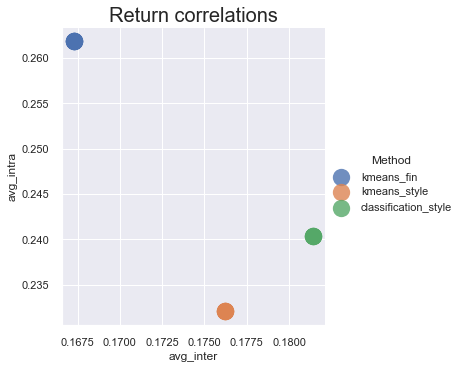

In [615]:
g = sns.lmplot(
    data=corr_df_concat,
    x="avg_inter", y="avg_intra", hue="Method",
    height=5,
    scatter_kws={"s": 300}
)

g.set_axis_labels("avg_inter", "avg_intra")
plt.title('Return correlations', fontsize=20)

(0.0, 0.3)

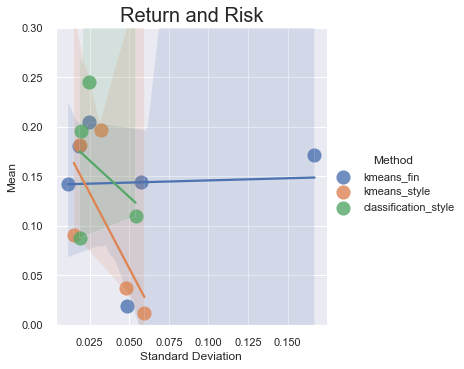

In [616]:
g = sns.lmplot(
    data=return_df_concat,
    x="Standard Deviation", y="Mean", hue="Method",
    height=5,
    scatter_kws={"s": 200}
)

g.set_axis_labels("Standard Deviation", "Mean")
plt.title('Return and Risk', fontsize=20)
plt.ylim(-0, 0.3)
